In [150]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import colors as mclr
from matplotlib import cm
import os 
import pickle

In [84]:
plt.rc('font', family = 'Times New Roman')
plt.rc('font', size = 14)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2.5)

In [85]:
figDirectory = "../figures/"

In [86]:
from demler_tools.file_manager import path_management, io

In [87]:
path_management.initialize(project_name = 'xy_qmc')

Successfully initialized path management with following parameters:
     username:                jcurtis
     project name:            xy_qmc
     controlling machine:     workstation
     library version:         v2.3.0-beta-1-g7645a25
     auto SSH transfer:       True
     default save location:   /scratch/savefiles
     LTS mount point:         /home
     email domain:            phys.ethz.ch
     cluster OS:              Ubuntu
     cluster partition:       work
     SSH host file:           /home/jcurtis/.ssh/known_hosts
     SSH key file:            /home/jcurtis/.ssh/id_ed25519_euler
     default modules:         {'CentOS': 'gcc/8.2.0 python/3.11.2', 'Ubuntu': 'stack/2024-06 python/3.11.6'}


In [115]:
timestamp = '1758283897'
job_no = io.recover_job_no(timestamp = timestamp)
inputs  = io.get_results(timestamp = timestamp,run_index = 0)[0]

In [232]:
def OP_statistics(OPs):
    ### First we compute the mean and variance of the order parameter over the sample 

    op = np.mean(np.abs(OPs))
    std = np.std(np.abs(OPs))

    return op,std 

def correlation(thetas):
    ### We compute there correlation function < e^(i theta(r) - itheta(0) ) > averaged over spacetime for different linear separations r 

    rotors = np.exp(1.j*thetas)

    L = thetas.shape[0]

    shifts = np.arange(L)

    output = np.zeros(L,dtype=complex)

    for i in range(L):
        output[i] = np.mean( np.roll(rotors,i,[0] )*np.conjugate(rotors) )

    return output

def vortex_statistics(vorts):
    ### We compute the mean vorticity and the variance 
    mean = np.mean(np.abs(vorts))
    std = np.std( np.abs(vorts))

    return mean, std 

def charge_statistics(angles):
    ### We compute the statistics of the charge fluctuations dtheta/dt 

    ### First we compute the derivative in time
    angles = np.unwrap(angles,axis=2)
    dthetadt = np.gradient(angles,axis=2)/inputs['dt']

    ### Next we compute the std dev of this 
    std = np.std(dthetadt)

    mean = np.mean(np.abs(dthetadt))
    return mean,std 

    
    

In [233]:
temps = np.zeros(job_no)
ops = np.zeros(job_no)
stds = np.zeros(job_no)
mean_vorts = np.zeros(job_no)
std_vorts = np.zeros(job_no) 
mean_charge = np.zeros(job_no)
std_charge = np.zeros(job_no)

correlation_function = np.zeros((inputs['L'],job_no),dtype=complex)


dt:  0.03
M:  8
T:  4.166666666666667


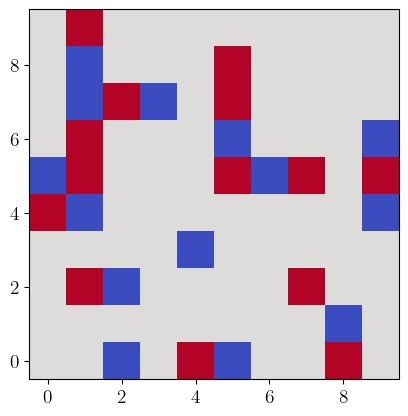

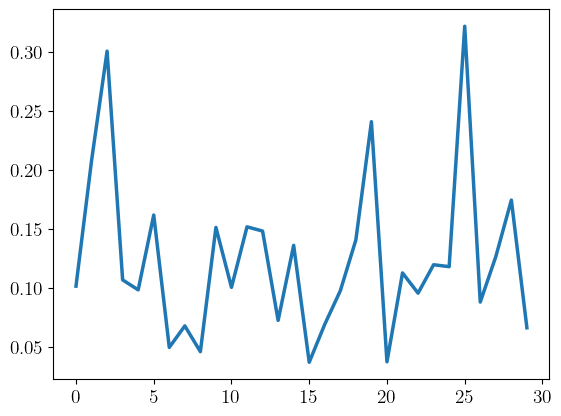

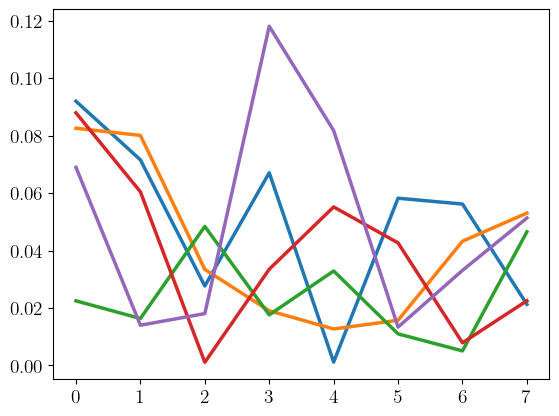

dt:  0.03
M:  12
T:  2.7777777777777777


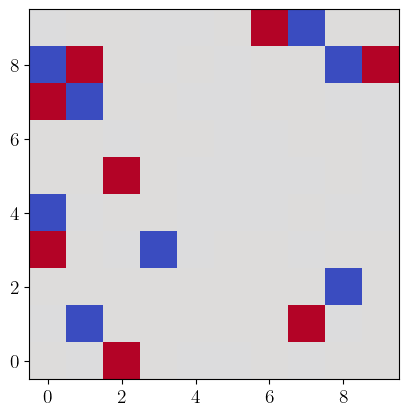

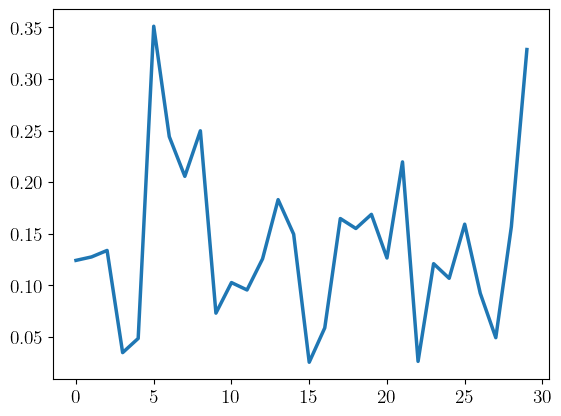

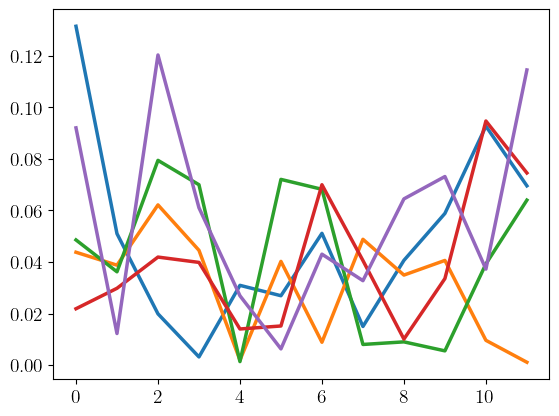

dt:  0.03
M:  16
T:  2.0833333333333335


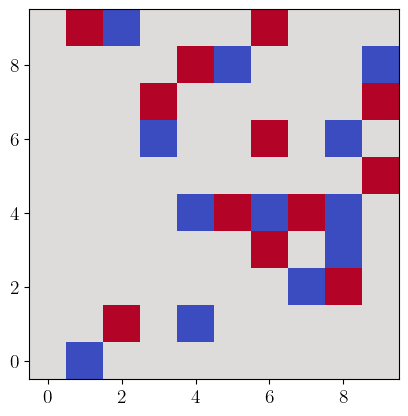

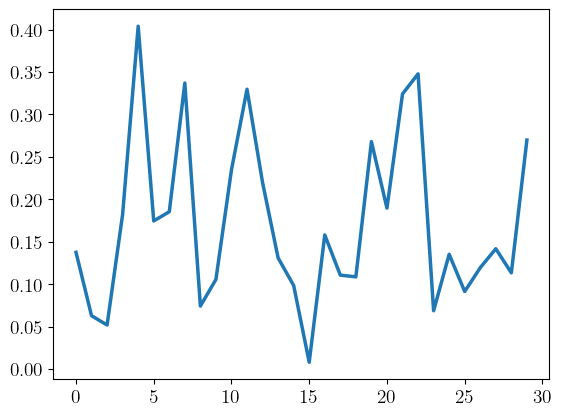

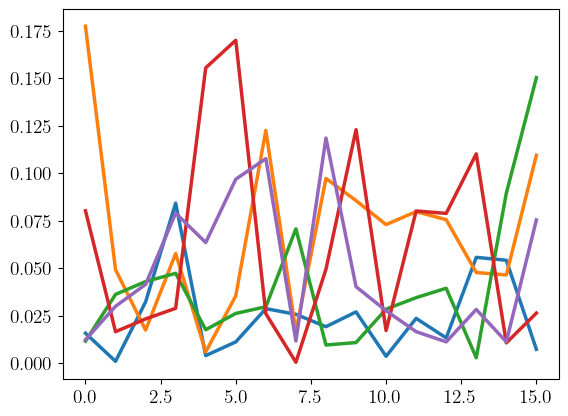

dt:  0.03
M:  24
T:  1.3888888888888888


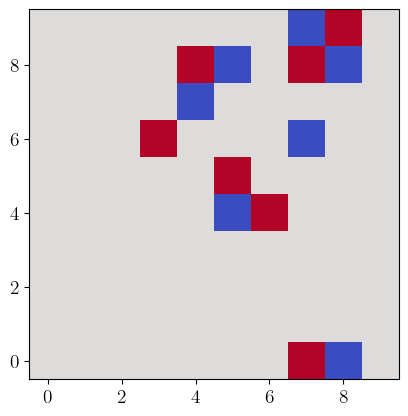

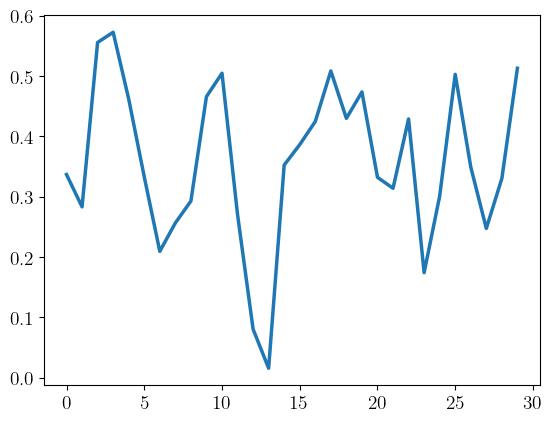

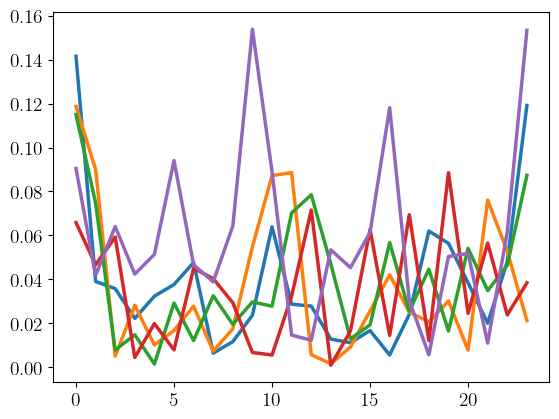

In [234]:
for job in range(job_no):
    inputs, data = io.get_results(timestamp = timestamp,run_index = job)
    actions,OPs,vorts,angles = data
    print("dt: ",str(inputs['dt']) )
    print("M: ",str(inputs['M']))
    T = 1./(inputs['dt']*inputs['M'])
    print("T: ",str(T))
    temps[job] = T 
    ops[job],stds[job] = OP_statistics(OPs)
    correlation_function[:,job] = correlation(angles) 
    av_vorts,st_vorts = vortex_statistics(vorts)
    mean_vorts[job] = av_vorts
    std_vorts[job] = st_vorts
    mean_charge[job], std_charge[job] = charge_statistics(angles)


    
    plt.imshow(np.transpose(vorts[:,:,0,-1]),origin='lower',cmap='coolwarm',norm=mclr.Normalize(-2.*np.pi,2.*np.pi) )
    plt.show()
    plt.plot(np.abs(OPs))
    plt.show()

    for j in range(0,20,4):
        plt.plot(np.abs(np.gradient(np.unwrap(angles,axis=2)[0,0,:,j])))
    plt.show()

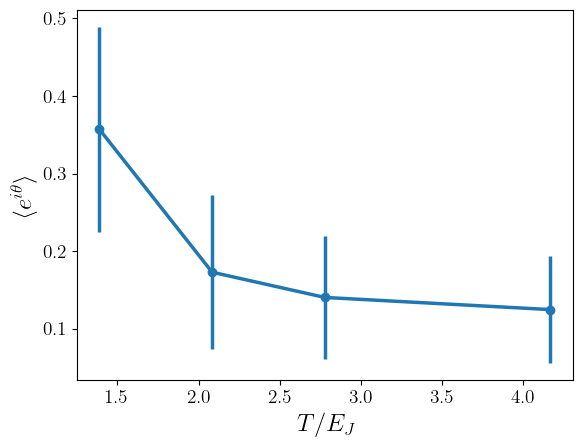

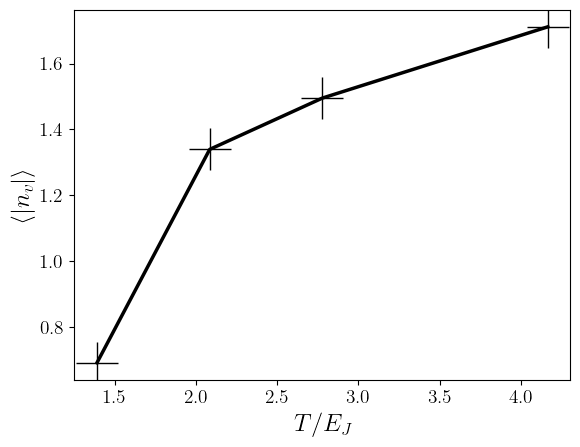

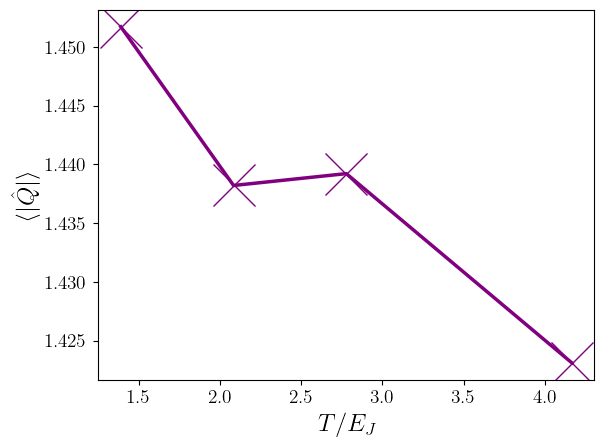

In [238]:
plt.errorbar(temps,ops,stds,marker='o')
plt.xlabel(r'$T/E_J$')
plt.ylabel(r'$\langle e^{i\theta}\rangle$')
plt.show()
plt.plot(temps,mean_vorts,marker='+',color='black',markersize=30)
plt.xlabel(r'$T/E_J$')
plt.ylabel(r'$\langle|n_v|\rangle$')
plt.show()
plt.errorbar(temps,mean_charge,marker='x',color='purple',markersize=30)
plt.xlabel(r'$T/E_J$')
plt.ylabel(r'$\langle |\hat{Q}| \rangle$')
plt.show()

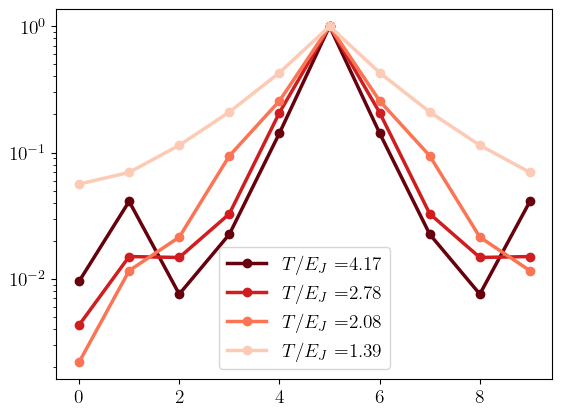

In [167]:
colors = cm.Reds(np.linspace(1.,0.2,job_no))
for job in range(job_no):
    plt.plot(np.roll(np.abs(correlation_function[:,job]), inputs['L']//2),'o-',color=colors[job] ,label=r'$T/E_J=$'+f"{temps[job]:0.2f}") 
plt.legend() 
plt.yscale('log')
plt.show()
